# A NOVEL BOOK RECOMMENDATION SYSTEM USING COMPUTER VISION

In [1]:
#libraries required

import os
import cv2
import imutils 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

### Parameters

In [2]:
# Parameter for comparing histograms
correl_threshold = 0.9

# Parameters for SSIM comparison
similarity_index_threshold = 0.0
ssim_matches_limit = 1000

# Parameters for SIFT comparision
sift_features_limit = 1000
lowe_ratio = 0.75
predictions_count = 4

# Parameters to display results
query_image_number =2
amazon_reviews_count = 3
rec_cnt=3

In [3]:
#Paths of all the files

def imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

### Loading the training dataset

In [4]:
train_paths = []
train_path = "D:/Project/book-cover-image-dataset/train"
for root, dirs, files in os.walk(train_path):
    for file in files:
        train_paths.append((os.path.join(root, file)))

### RGB Color histograms of training images

In [5]:
%%time

hist_train = []
for path in train_paths:
    image = cv2.imread(path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_train.append((path,hist))

Wall time: 1min 47s


In [6]:
# Saving the train data histograms to a pickle file
with open('train_hist_data.pkl', 'wb') as f:
    pickle.dump(hist_train, f)

In [7]:
# Loading the train data histograms from pickle file
with open('train_hist_data.pkl', 'rb') as f:
    hist_train = pickle.load(f)

### RGB Color histograms of query images

In [8]:
#Reading the test images
query_path = "D:/Project/book-cover-image-dataset/test"
query_paths = imlist(query_path)

In [9]:
hist_query = []
for path in query_paths:
    image = cv2.imread(path)
    if image is None:
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_query.append((path,hist))

### Level-1 Matcher by correlation

In [10]:
%%time

hist_matches = []
for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches))

Wall time: 445 ms


### Level-2 Matcher by SSIM

In [11]:
def similarity_index(q_path,m_path):
    q_i = cv2.imread(q_path,0)
    q_i = cv2.resize(q_i,(8,8))
    m_i = cv2.imread(m_path,0)
    m_i = cv2.resize(m_i,(8,8))
    return ssim(q_i,m_i)

In [12]:
%%time

ssim_matches = []

for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

Wall time: 19.4 s


### Level-3 Matcher by FLANN using SIFT features

In [13]:
#Function to generate SIFT descriptors
def gen_sift_features(image):
    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

In [14]:
# FLANN matcher

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [15]:
%%time

predictions = []
for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image
    q_path = ssim_matches[i][0]
    q_img = cv2.imread(q_path)
    if q_img is None:
        continue
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    # Generating SIFT features for query image
    q_kp,q_des = gen_sift_features(q_img)
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        m_img = cv2.imread(m_path)        
        if m_img is None:
            continue
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for predicted ssim images
        m_kp,m_des = gen_sift_features(m_img)
        if m_des is None:
            continue
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des,m_des,k=2)
        #ratio query as per Lowe's paper
        matches_count = 0
        for x,(m,n) in enumerate(matches):
            if m.distance < lowe_ratio*n.distance:
                matches_count += 1
        matches_flann.append((matches_count,m_path))
    matches_flann.sort(key=lambda x : x[0] , reverse = True)
    predictions.append((q_path,matches_flann[:predictions_count]))

Wall time: 1min 1s


In [16]:
indexes=[]
for i in range(query_image_number):
    if(predictions[i][1][0][0]<200):
        indexes.append(i)

### Displaying the predicted images 

In [17]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

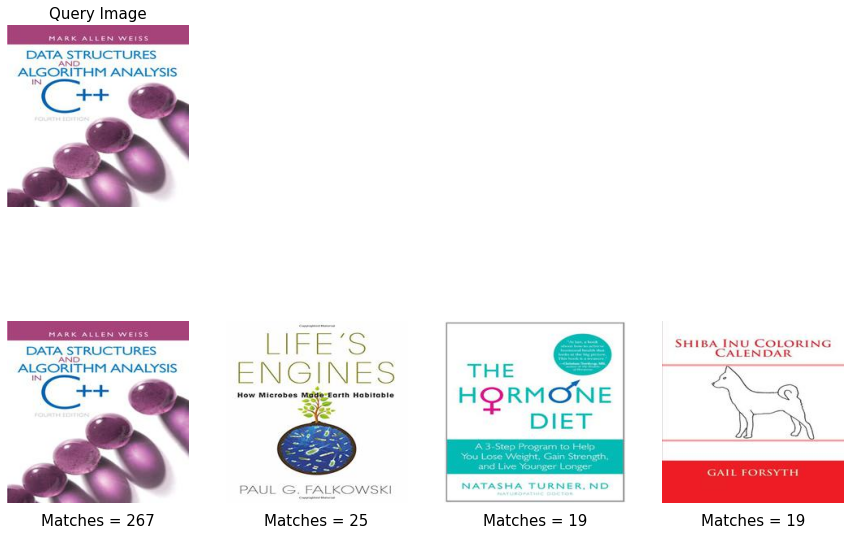

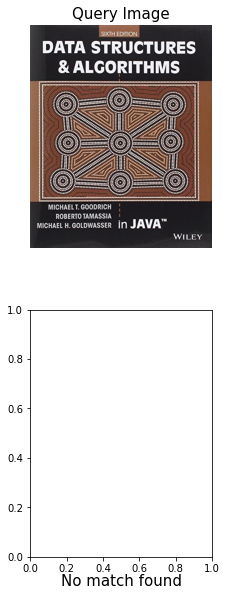

In [18]:
for j in range (query_image_number):
    # Loading query image
    title_text = ""
    plt.figure(figsize=(15,10))
    query_image = cv2.imread(predictions[j][0])
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, 1)
    plt.axis('off')
    plt.title("Query Image",fontsize=15)
    plt.imshow(query_image)
    top_prediction_image = cv2.imread(predictions[j][1][0][1])
    top_prediction_image = cv2.cvtColor(top_prediction_image, cv2.COLOR_BGR2RGB)
    # Loading predicted images
    for i in range(predictions_count):
        title_text = ""
        if j in indexes:
            title_text = "No match found"
            plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
            break
        img = cv2.imread(predictions[j][1][i][1])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title_text = "Matches = " + str(predictions[j][1][i][0])
        plt.subplot(2,4,5+i)
        plt.axis('off')
        plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
        plt.imshow(img)
    plt.show()

### Removing the Images which doesn't match

In [19]:
for index in sorted(indexes, reverse=True):
    del predictions[index]

### Drawing Key Points matches



For Query image :  1 




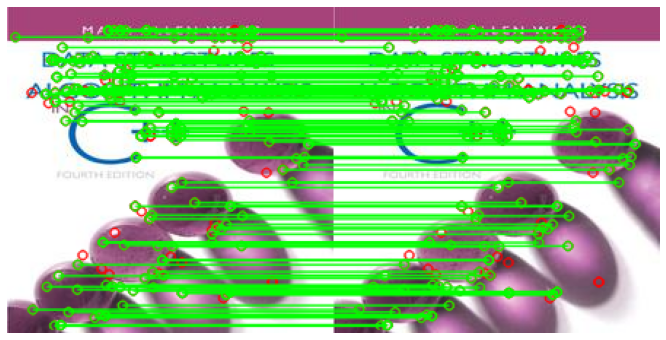

In [20]:
import random
k=0
for j in range (len(predictions)):
    print("\n\nFor Query image : ",k+1,"\n\n")
    k+=1
    query_image = cv2.imread(predictions[j][0])
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    top_prediction_image = cv2.imread(predictions[j][1][0][1])
    top_prediction_image = cv2.cvtColor(top_prediction_image, cv2.COLOR_BGR2RGB)
    q_kp,q_des = gen_sift_features(query_image)
    m_kp,m_des = gen_sift_features(top_prediction_image)
    matches_old = flann.knnMatch(q_des,m_des,k=2)
    matches = random.sample(matches_old,200)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < lowe_ratio*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)
    kp_img = cv2.drawMatchesKnn(query_image,q_kp,top_prediction_image,m_kp,matches,None,**draw_params)
    plt.figure(figsize=(16,6))
    plt.axis('off')
    plt.imshow(kp_img)
    plt.show()

### Details of the top predicted books

In [21]:
import requests
import csv
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

In [22]:
import re
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [23]:
isbn=[]
from pathlib import Path
for i in range(len(predictions)):
    isbn.append(Path(predictions[i][1][0][1]).stem)

In [24]:
def book_details_amazon(isbn):
    
    # Amazon Scraping
    amazon_base_url = "https://www.amazon.com/dp/"
    amazon_url = amazon_base_url + isbn
    req = Request(amazon_url, headers={'User-Agent': 'Chrome/80.0.3987.122'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    # Book title
    a_title = soup.find_all("span",id="productTitle")
    a_title = str(a_title)
    a_title = remove_tags(a_title)
    a_title = a_title.strip("[]")
    a_title = a_title.strip()
    
    # Book details
    book_info = []
    for li in soup.select('table#productDetailsTable div.content ul li'):
        try:
            title = li.b
            key = title.text.strip().rstrip(':')
            value = title.next_sibling.strip()
            value = value.strip("()")
            book_info.append((key,value))
        except AttributeError:
            break
            
    # Amazon reviews scraping
    amazon_review_base_url = "https://www.amazon.com/product-reviews/"
    amazon_review_url = amazon_review_base_url + isbn + "/ref=cm_cr_getr_d_paging_btm_2?pageNumber="
    req = Request(amazon_review_url, headers={'User-Agent': 'Chrome/80.0.3987.122'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    # List of book reviews in Amazon
    reviews_list = []
    reviews_list_final = []
    for pg in range(1,5):
        amazon_review_url = amazon_review_base_url + isbn + "/ref=cm_cr_getr_d_paging_btm_2?pageNumber=" + str(pg)
        req = Request(amazon_review_url, headers={'User-Agent': 'Chrome/80.0.3987.122'})
        page = urlopen(req).read().decode("utf-8")
        soup = BeautifulSoup(page, 'html.parser')

        txt = soup.find("div", id="cm_cr-review_list")
        try:
            for rawreview in txt.find_all('span', {'class' : 'a-size-base review-text review-text-content'}):
                text = rawreview.parent.parent.parent.text
                startindex = text.find('5.0 out of 5 stars')
                if startindex==-1:
                    continue
                startindex = text.index('5 stars') + 7
                endindex = text.index('Helpful')
                text = text[startindex:endindex]
                rText = text.split(".")
                review_text = ""
                for i in range(len(rText)):
                    review_text += rText[i]
                    review_text += "."
                if review_text is not "":
                    if "|" not in review_text:
                        reviews_list.append(review_text)
                    else:
                        rText = text.split(".")
                        review_text = ""
                        for x in range(len(rText)):
                            review_text += rText[x]
                            review_text += "."
                        reviews_list.append(review_text)
        except AttributeError:
            review_text = "No reviews found."
    
    if amazon_reviews_count < len(reviews_list):
        reviews_list_final = reviews_list[:amazon_reviews_count]
    else:
        reviews_list_final = reviews_list
        
    # Printing book details from Amazon
    print("Book Title: ",a_title)
    #print("\n")
    for i in range(len(book_info)):
        print(f"{book_info[i][0]} : {book_info[i][1]}")
        #print("\n")
    print("\n")
    # Book Description
    goodreads_base_url = "https://www.goodreads.com/book/isbn/"
    goodreads_url = goodreads_base_url + isbn
    req = Request(goodreads_url, headers={'User-Agent': 'Chrome/80.0.3987.122'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    desc = soup.find("div", id="description")
    if desc is not None:
        desc = desc.find_all("span",style="display:none")
        if desc is not None:
            desc = str(desc)
            desc = remove_tags(desc)
            description = desc.strip("[]")
            description = description.strip()
        else:
            description = "No description found"
    else:
        description = "No description found"
    print("\n\nDescription of the book:\n\n")
    print(description)
    print("\n\n")
    if len(reviews_list_final) == 0:
        print(review_text)
        print("\n")
    else:
        print(f"Displaying top {amazon_reviews_count} book reviews:\n")
        for i in range(len(reviews_list_final)):
            review_txt_list = reviews_list_final[i].split(".")
            review_txt = ""
            for j in range(len(review_txt_list)):
                review_txt += review_txt_list[j]
                review_txt += "."
            review_txt += ".."
            print(review_txt)
            print("\n")

In [25]:
print("Books Details from Amazon")
for i in range(len(isbn)):
    print("\n\nFor Query image : ",i+1,"\n\n")
    book_details_amazon(isbn[i])

Books Details from Amazon


For Query image :  1 


Book Title:  Data Structures &amp; Algorithm Analysis in C++
Hardcover : 664 pages
Publisher : Pearson; 4 edition (June 23, 2013
Language : English
ISBN-10 : 013284737X
ISBN-13 : 978-0132847377
Product Dimensions : 1.1 x 7.5 x 9.2 inches
Shipping Weight : 2.4 pounds 
Customer Reviews : 
Amazon Best Sellers Rank : #681,866 in Books 




Description of the book:


Data Structures and Algorithm Analysis in C++  is an advanced algorithms book that bridges the gap between traditional CS2 and Algorithms Analysis courses. As the speed and power of computers increases, so does the need for effective programming and algorithm analysis. By approaching these skills in tandem, Mark Allen Weiss teaches readers to develop well-constructed, maximally efficient programs using the C++ programming language.This book explains topics from binary heaps to sorting to NP-completeness, and dedicates a full chapter to amortized analysis and advanced data stru

### Books written by the same author

In [26]:
from pathlib import Path
df=pd.read_csv(r"D:\Project\book-cover-image-dataset\dataset.csv",sep=',')
k=1
for j in isbn:
    print("\n\nFor Query image : ",k,"\n\n")
    k=k+1
    a=df[df['Asni'] == j]
    f=df[df['Author'] == a['Author'].values[0]]
    l=len(f)-1
    if l==0 :
        print("No Other books found")
    else:
        val=0
        for i in range(len(f)):
            if f[i:i+1]['Asni'].values[0] == j:
                continue
            val=val+1
            print("\nBook No: ",val," : \n")
            print("ASNI : ",f[i:i+1]['Asni'].values[0])
            print("IMG_URL : ",f[i:i+1]['Iurl'].values[0])
            print("TITLE : ",f[i:i+1]['Title'].values[0])
            print("AUTHOR : ",f[i:i+1]['Author'].values[0])
            print("CATOGERY : ",f[i:i+1]['Catogery'].values[0])



For Query image :  1 



Book No:  1  : 

ASNI :  132576279
IMG_URL :  http://ecx.images-amazon.com/images/I/51En%2BB0E1GL.jpg
TITLE :  Data Structures and Algorithm Analysis in Java (3rd Edition)
AUTHOR :  Mark A. Weiss
CATOGERY :  Computers & Technology

Book No:  2  : 

ASNI :  201498405
IMG_URL :  http://ecx.images-amazon.com/images/I/410K3XZZ29L.jpg
TITLE :  Data Structures and Algorithm Analysis in C (2nd Edition)
AUTHOR :  Mark A. Weiss
CATOGERY :  Computers & Technology


### Recommended books of similar catogery

In [27]:
df1=pd.read_csv(r"D:\Project\book-cover-image-dataset\rating.csv",sep=',',usecols=['product_id','star_rating','total_votes'])

In [28]:
k=1
for j in isbn:
    #Extracting ASIN of that catogery
    a=df[df['Asni'] == j]
    f=df[df['Cid'] == a['Cid'].values[0]]
    l=f['Asni'].values
    #Matching list of ASIN in Review dataset
    df2=df1[df1['product_id'].isin(l)]
    #Soting the matched one in decending order of star_count,total_votes
    Norm_val=[]
    sval=df2['star_rating'].values
    tval=df2['total_votes'].values
    for i in range(0,len(df2)):
        Norm_val.append(sval[i]*tval[i])
    df2=df2.assign(Normalized_Count = Norm_val)
    df3=df2.sort_values(['Normalized_Count'],ascending=False)
    #Extracting requird info
    r=df3[0:rec_cnt]['product_id'].values
    s=df3[0:rec_cnt]['star_rating'].values
    t=df3[0:rec_cnt]['total_votes'].values
    #Diplaying detials
    print("\n\nCatogery of Book ",k," : ",a['Catogery'].values[0],"\n\n")
    k=k+1;
    print("Recommended books of ",a['Catogery'].values[0],"catogery :")
    for i in range(len(r)):
        a=df[df['Asni'] == r[i]]
        print("\nBook No: ",i+1," : \n")
        print("ASNI : ",a['Asni'].values[0])
        print("TITLE : ",a['Title'].values[0])
        print("AUTHOR : ",a['Author'].values[0])
        print("RATING : ",s[i])
        print("TOTAL VOTES : ",t[i])



Catogery of Book  1  :  Computers & Technology 


Recommended books of  Computers & Technology catogery :

Book No:  1  : 

ASNI :  670033847
TITLE :  The Singularity Is Near: When Humans Transcend Biology
AUTHOR :  Ray Kurzweil
RATING :  4.0
TOTAL VOTES :  805.0

Book No:  2  : 

ASNI :  201835959
TITLE :  The Mythical Man-Month: Essays on Software Engineering, Anniversary Edition (2nd Edition)
AUTHOR :  Frederick P. Brooks Jr.
RATING :  5.0
TOTAL VOTES :  399.0

Book No:  3  : 

ASNI :  201633612
TITLE :  Design Patterns: Elements of Reusable Object-Oriented Software
AUTHOR :  Erich Gamma
RATING :  4.0
TOTAL VOTES :  479.0
